In [1]:
import pandas as pd

Y_df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')

Y_df.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


In [2]:
uids = Y_df['unique_id'].unique()[:10] # Select 10 ids to make the example faster
Y_df = Y_df.query('unique_id in @uids').reset_index(drop=True)

/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.10/site-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


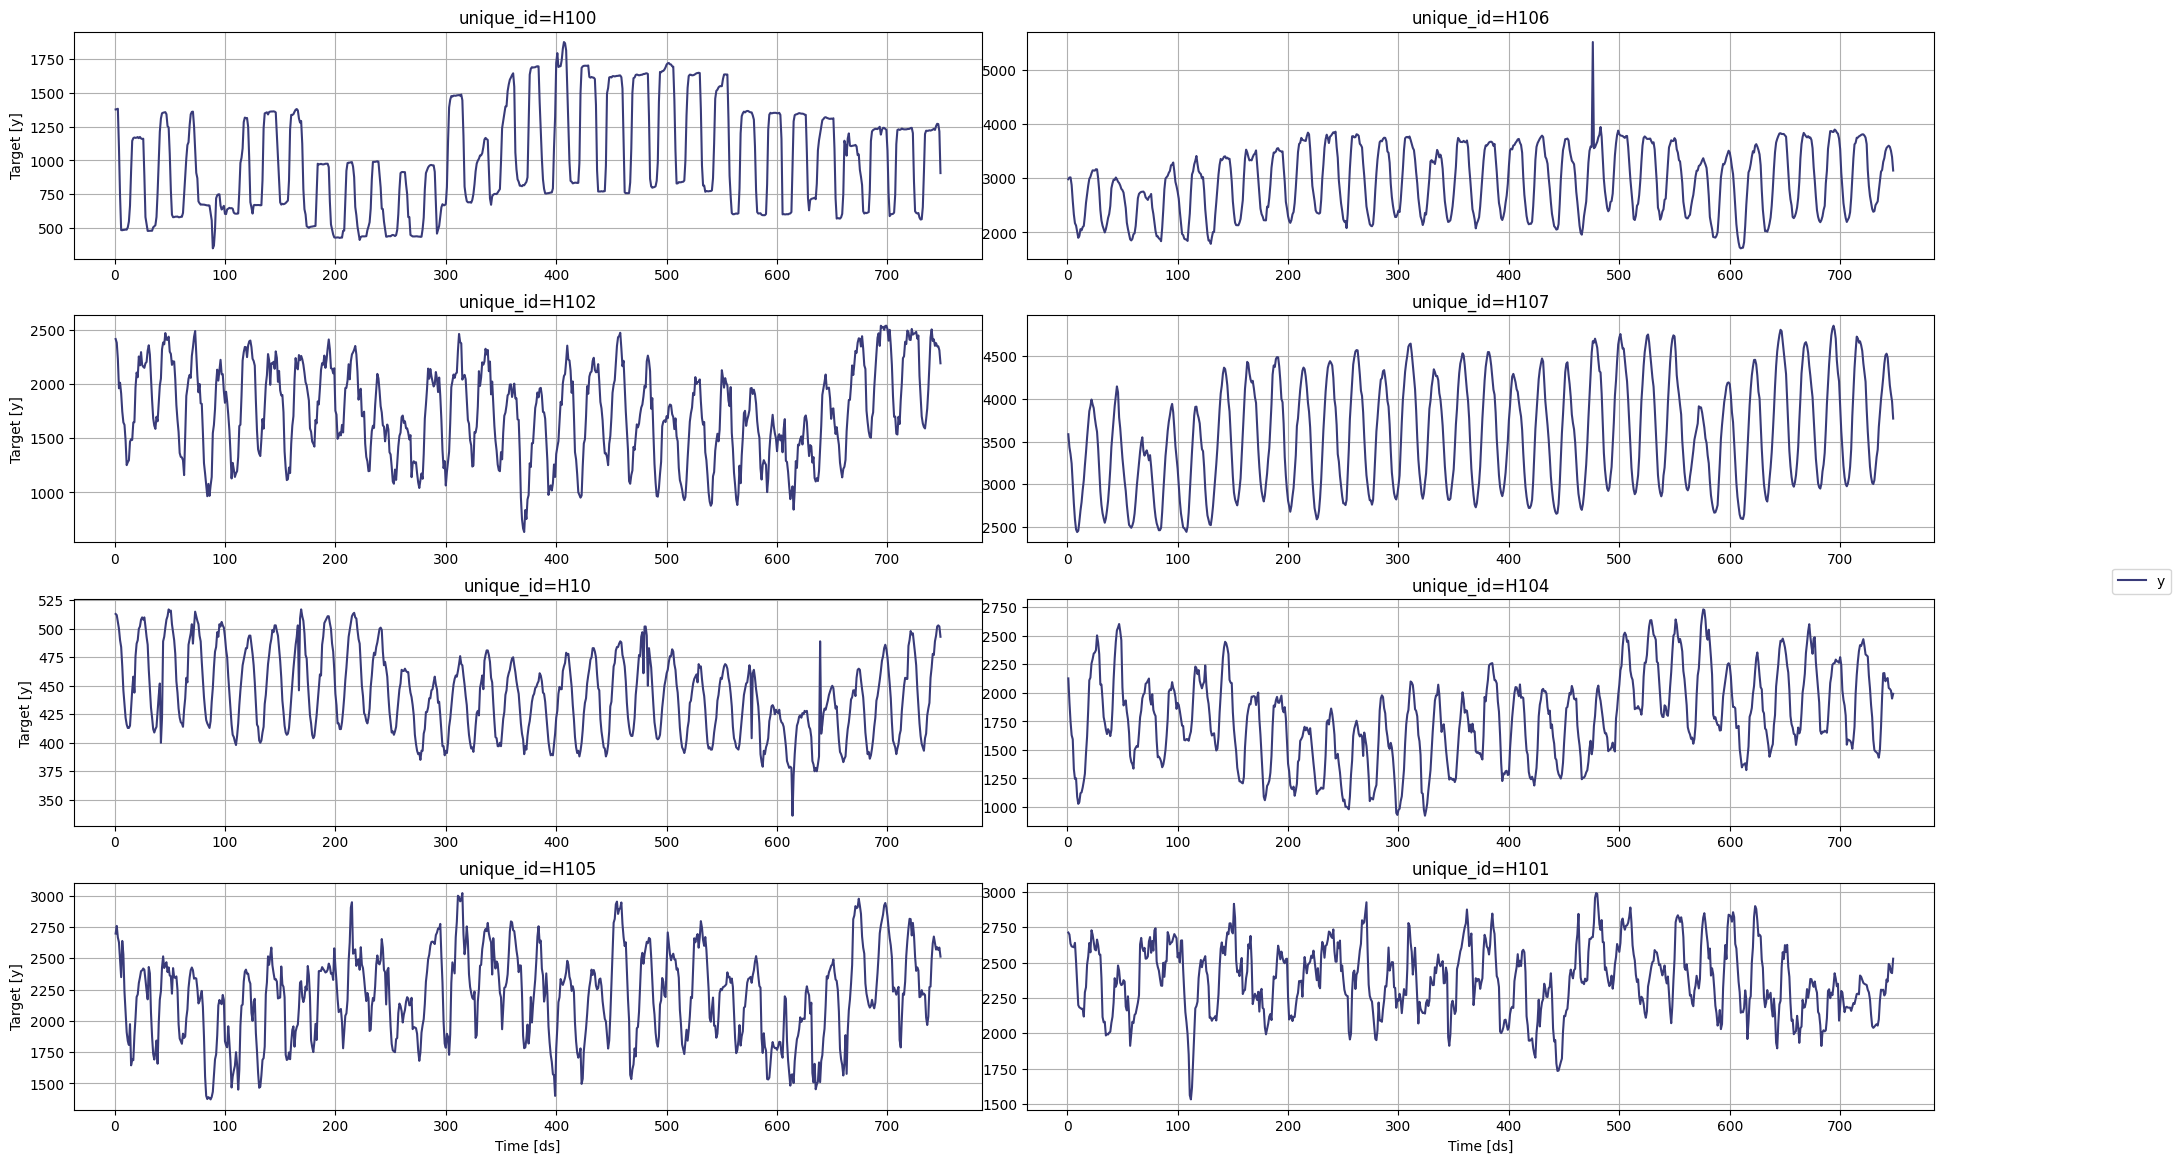

In [3]:
from statsforecast import StatsForecast

StatsForecast.plot(Y_df, engine='matplotlib') 

In [4]:
from ray import tune

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MQLoss

In [5]:
config_nhits = {
    "input_size": tune.choice([48, 48*2, 48*3]),              # Length of input window
    "start_padding_enabled": True,
    "n_blocks": 5*[1],                                              # Length of input window
    "mlp_units": 5 * [[64, 64]],                                  # Length of input window
    "n_pool_kernel_size": tune.choice([5*[1], 5*[2], 5*[4],         
                                      [8, 4, 2, 1, 1]]),            # MaxPooling Kernel size
    "n_freq_downsample": tune.choice([[8, 4, 2, 1, 1],
                                      [1, 1, 1, 1, 1]]),            # Interpolation expressivity ratios
    "learning_rate": tune.loguniform(1e-4, 1e-2),                   # Initial Learning rate
    "scaler_type": tune.choice([None]),                             # Scaler type
    "max_steps": tune.choice([1000]),                               # Max number of training iterations
    "batch_size": tune.choice([1, 4, 10]),                          # Number of series in batch
    "windows_batch_size": tune.choice([128, 256, 512]),             # Number of windows in batch
    "random_seed": tune.randint(1, 20),                             # Random seed
}

config_lstm = {
    "input_size": tune.choice([48, 48*2, 48*3]),              # Length of input window
    "encoder_hidden_size": tune.choice([64, 128]),            # Hidden size of LSTM cells
    "encoder_n_layers": tune.choice([2,4]),                   # Number of layers in LSTM
    "learning_rate": tune.loguniform(1e-4, 1e-2),             # Initial Learning rate
    "scaler_type": tune.choice(['robust']),                   # Scaler type
    "max_steps": tune.choice([500, 1000]),                    # Max number of training iterations
    "batch_size": tune.choice([1, 4]),                        # Number of series in batch
    "random_seed": tune.randint(1, 20),                       # Random seed
}

In [8]:
nf = NeuralForecast(
    models=[
        AutoNHITS(h=48, config=config_nhits, loss=MQLoss(), num_samples=5),
        AutoLSTM(h=48, config=config_lstm, loss=MQLoss(), num_samples=2),
    ],
    freq='H'
)

In [9]:
nf.fit(df=Y_df)

2024-04-13 11:20:59,019	ERROR tune_controller.py:1332 -- Trial task failed for trial _train_tune_33873_00000
Traceback (most recent call last):
  File "/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.10/site-packages/ray/_private/worker.py", line 2667, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/Users/martinfabbri/Workspace/github/crypto-qua

RuntimeError: No best trial found for the given metric: loss. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.